#**Libraries**

In [ ]:
# Install OpenCV
!pip install opencv-python

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Concatenate, Activation, AveragePooling2D, MaxPooling2D
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import Conv2d
from torchvision import transforms

#**Lineaer Interpolation**

In [ ]:
def linear_interpolation(image, new_height, new_width):
    # Calculate scaling factors
    orig_height, orig_width = image.shape[:2]
    sx = new_width / orig_width
    sy = new_height / orig_height

    # Create a new output image
    output_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    return output_image

def add_white_pixels(image, x_pixels, y_pixels):
    # Get the dimensions of the original image
    h, w = image.shape[:2]

    # Create a copy of the original image
    output_image = image.copy()

    # Add white pixels to the boundaries
    output_image = cv2.copyMakeBorder(output_image, y_pixels, y_pixels, x_pixels, x_pixels, cv2.BORDER_CONSTANT, value=[255, 255, 255])

    return output_image




#Image

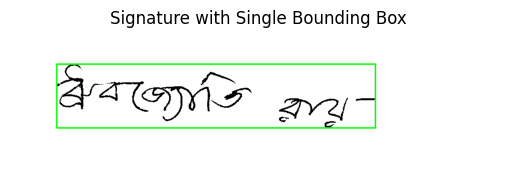

In [ ]:
# Load the image
image = cv2.imread("/content/B-S-1-G-03.tif")
# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to obtain binary image
_, threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

# Find contours in the binary image
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the overall bounding box of all contours
x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    x_min = min(x_min, x)
    y_min = min(y_min, y)
    x_max = max(x_max, x + w)
    y_max = max(y_max, y + h)

# Crop the image using the overall bounding box
cropped_image = image[y_min:y_max, x_min:x_max]

# Save the cropped image
cv2.imwrite("B-S-1-G-03_cropped.tif", cropped_image)

# Draw the overall bounding box on the image
cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Convert the image from BGR to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box using matplotlib
plt.imshow(image_rgb)
plt.title("Signature with Single Bounding Box")
plt.axis("off")
plt.show()

In [ ]:
# Load the original image
original_image = cv2.imread("/content/B-S-1-G-03_cropped.tif")

# Resize the original cropped image to different dimensions
resized_image_1 = linear_interpolation(original_image, 50, 150)

# Add white pixels to the boundaries of each resized image
image_with_white_pixels_1 = add_white_pixels(resized_image_1, 0, 0)
image_with_white_pixels_2 = add_white_pixels(resized_image_1, 15, 5)
image_with_white_pixels_3 = add_white_pixels(resized_image_1, 30, 10)

# Save the images with white pixels
cv2.imwrite("/content/B-S-1-G-03_resized_1.tif", image_with_white_pixels_1)
cv2.imwrite("/content/B-S-1-G-03_resized_2.tif", image_with_white_pixels_2)
cv2.imwrite("/content/B-S-1-G-03_resized_3.tif", image_with_white_pixels_3)


True

In [ ]:
# Read the image
image_1 = Image.open('/content/B-S-1-G-03_resized_1.tif')
image_2 = Image.open('/content/B-S-1-G-03_resized_2.tif')
image_3 = Image.open('/content/B-S-1-G-03_resized_3.tif')
# Define a transform to convert the image to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Convert the image to tensor
img_tensor_1 = transform(image_1)
img_tensor_2 = transform(image_2)
img_tensor_3 = transform(image_3)

# Print the converted Torch tensor
print(img_tensor_1.shape)
print(img_tensor_2.shape)
print(img_tensor_3.shape)

torch.Size([3, 50, 150])
torch.Size([3, 60, 180])
torch.Size([3, 70, 210])


#**First Network**

#**First Branch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        # First Block
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Block
        self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Block
        self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth Block
        self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First Block
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv5(x))
        x = self.pool1(x)

        # Second Block
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = F.relu(self.conv8_1(x))
        x = F.relu(self.conv8_2(x))
        x = F.relu(self.conv9_1(x))
        x = F.relu(self.conv9_2(x))
        x = F.relu(self.conv10_1(x))
        x = F.relu(self.conv10_2(x))
        x = F.relu(self.conv11_1(x))
        x = F.relu(self.conv11_2(x))
        x = F.relu(self.conv12_1(x))
        x = F.relu(self.conv12_2(x))
        x = F.relu(self.conv13_1(x))
        x = F.relu(self.conv13_2(x))
        x = F.relu(self.conv14(x))
        x = self.pool2(x)

        # Third Block
        x = F.relu(self.conv15_1(x))
        x = F.relu(self.conv15_2(x))
        x = F.relu(self.conv16_1(x))
        x = F.relu(self.conv16_2(x))
        x = F.relu(self.conv17_1(x))
        x = F.relu(self.conv17_2(x))
        x = F.relu(self.conv18_1(x))
        x = F.relu(self.conv18_2(x))
        x = F.relu(self.conv19_1(x))
        x = F.relu(self.conv19_2(x))
        x = F.relu(self.conv20_1(x))
        x = F.relu(self.conv20_2(x))
        x = F.relu(self.conv21_1(x))
        x = F.relu(self.conv21_2(x))
        x = F.relu(self.conv22_1(x))
        x = F.relu(self.conv22_2(x))
        x = F.relu(self.conv23_1(x))
        x = F.relu(self.conv23_2(x))
        x = F.relu(self.conv24_1(x))
        x = F.relu(self.conv24_2(x))
        x = F.relu(self.conv25_1(x))
        x = F.relu(self.conv25_2(x))
        x = F.relu(self.conv26_1(x))
        x = F.relu(self.conv26_2(x))
        x = F.relu(self.conv27_1(x))
        x = F.relu(self.conv27_2(x))
        x = F.relu(self.conv28_1(x))
        x = F.relu(self.conv28_2(x))
        x = F.relu(self.conv29_1(x))
        x = F.relu(self.conv29_2(x))
        x = F.relu(self.conv30_1(x))
        x = F.relu(self.conv30_2(x))
        x = F.relu(self.conv31(x))
        x = self.pool3(x)

        # Fourth Block
        x = F.relu(self.conv32_1(x))
        x = F.relu(self.conv32_2(x))
        x = F.relu(self.conv33_1(x))
        x = F.relu(self.conv33_2(x))
        x = F.relu(self.conv34_1(x))
        x = F.relu(self.conv34_2(x))
        x = F.relu(self.conv35_1(x))
        x = F.relu(self.conv35_2(x))
        x = F.relu(self.conv36_1(x))
        x = F.relu(self.conv36_2(x))
        x = F.relu(self.conv37_1(x))
        x = F.relu(self.conv37_2(x))
        x = F.relu(self.conv38_1(x))
        x = F.relu(self.conv38_2(x))
        x = F.relu(self.conv39_1(x))
        x = F.relu(self.conv39_2(x))
        x = F.relu(self.conv40_1(x))
        x = F.relu(self.conv40_2(x))
        x = F.relu(self.conv41_1(x))
        x = F.relu(self.conv41_2(x))
        x = F.relu(self.conv42_1(x))
        x = F.relu(self.conv42_2(x))
        x = F.relu(self.conv43_1(x))
        x = F.relu(self.conv43_2(x))
        x = F.relu(self.conv44(x))
        x = self.pool4(x)

        return x

# Example usage:
# Initialize the network
net = CustomNetwork()
# Create a random input tensor of shape (batch_size, channels, height, width)
input_tensor_1 = img_tensor_1
# Forward pass
output_tensor_1 = net(input_tensor_1)
print("Output tensor shape:", output_tensor_1.shape)


Output tensor shape: torch.Size([48, 3, 9])


#**Second Branch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        # First Block
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Block
        self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Block
        self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth Block
        self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First Block
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv5(x))
        x = self.pool1(x)

        # Second Block
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = F.relu(self.conv8_1(x))
        x = F.relu(self.conv8_2(x))
        x = F.relu(self.conv9_1(x))
        x = F.relu(self.conv9_2(x))
        x = F.relu(self.conv10_1(x))
        x = F.relu(self.conv10_2(x))
        x = F.relu(self.conv11_1(x))
        x = F.relu(self.conv11_2(x))
        x = F.relu(self.conv12_1(x))
        x = F.relu(self.conv12_2(x))
        x = F.relu(self.conv13_1(x))
        x = F.relu(self.conv13_2(x))
        x = F.relu(self.conv14(x))
        x = self.pool2(x)

        # Third Block
        x = F.relu(self.conv15_1(x))
        x = F.relu(self.conv15_2(x))
        x = F.relu(self.conv16_1(x))
        x = F.relu(self.conv16_2(x))
        x = F.relu(self.conv17_1(x))
        x = F.relu(self.conv17_2(x))
        x = F.relu(self.conv18_1(x))
        x = F.relu(self.conv18_2(x))
        x = F.relu(self.conv19_1(x))
        x = F.relu(self.conv19_2(x))
        x = F.relu(self.conv20_1(x))
        x = F.relu(self.conv20_2(x))
        x = F.relu(self.conv21_1(x))
        x = F.relu(self.conv21_2(x))
        x = F.relu(self.conv22_1(x))
        x = F.relu(self.conv22_2(x))
        x = F.relu(self.conv23_1(x))
        x = F.relu(self.conv23_2(x))
        x = F.relu(self.conv24_1(x))
        x = F.relu(self.conv24_2(x))
        x = F.relu(self.conv25_1(x))
        x = F.relu(self.conv25_2(x))
        x = F.relu(self.conv26_1(x))
        x = F.relu(self.conv26_2(x))
        x = F.relu(self.conv27_1(x))
        x = F.relu(self.conv27_2(x))
        x = F.relu(self.conv28_1(x))
        x = F.relu(self.conv28_2(x))
        x = F.relu(self.conv29_1(x))
        x = F.relu(self.conv29_2(x))
        x = F.relu(self.conv30_1(x))
        x = F.relu(self.conv30_2(x))
        x = F.relu(self.conv31(x))
        x = self.pool3(x)

        # Fourth Block
        x = F.relu(self.conv32_1(x))
        x = F.relu(self.conv32_2(x))
        x = F.relu(self.conv33_1(x))
        x = F.relu(self.conv33_2(x))
        x = F.relu(self.conv34_1(x))
        x = F.relu(self.conv34_2(x))
        x = F.relu(self.conv35_1(x))
        x = F.relu(self.conv35_2(x))
        x = F.relu(self.conv36_1(x))
        x = F.relu(self.conv36_2(x))
        x = F.relu(self.conv37_1(x))
        x = F.relu(self.conv37_2(x))
        x = F.relu(self.conv38_1(x))
        x = F.relu(self.conv38_2(x))
        x = F.relu(self.conv39_1(x))
        x = F.relu(self.conv39_2(x))
        x = F.relu(self.conv40_1(x))
        x = F.relu(self.conv40_2(x))
        x = F.relu(self.conv41_1(x))
        x = F.relu(self.conv41_2(x))
        x = F.relu(self.conv42_1(x))
        x = F.relu(self.conv42_2(x))
        x = F.relu(self.conv43_1(x))
        x = F.relu(self.conv43_2(x))
        x = F.relu(self.conv44(x))
        x = self.pool4(x)

        return x

# Example usage:
# Initialize the network
net = CustomNetwork()
# Create a random input tensor of shape (batch_size, channels, height, width)
input_tensor_2 = img_tensor_2
# Forward pass
output_tensor_2 = net(input_tensor_2)
print("Output tensor shape:", output_tensor_2.shape)


Output tensor shape: torch.Size([48, 3, 11])


#**Third Branch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        # First Block
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv3_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv3_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv4_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.conv4_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Block
        self.conv6_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv6_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv7_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv7_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv8_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv8_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv9_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv9_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv10_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv10_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv11_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv11_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv12_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv12_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv13_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.conv13_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Block
        self.conv15_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv15_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv16_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv16_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv17_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv17_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv18_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv18_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv19_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv19_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv20_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv20_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv21_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv21_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv22_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv22_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv23_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv23_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv24_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv24_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv25_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv25_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv26_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv26_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv27_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv27_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv28_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv28_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv29_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv29_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv30_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv30_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth Block
        self.conv32_1 = nn.Conv2d(in_channels=64, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv32_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv33_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv33_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv34_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv34_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv35_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv35_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv36_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv36_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv37_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv37_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv38_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv38_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv39_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv39_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv40_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv40_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv41_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv41_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv42_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv42_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv43_1 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.conv43_2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv44 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=1, stride=1, padding=0)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First Block
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv5(x))
        x = self.pool1(x)

        # Second Block
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = F.relu(self.conv8_1(x))
        x = F.relu(self.conv8_2(x))
        x = F.relu(self.conv9_1(x))
        x = F.relu(self.conv9_2(x))
        x = F.relu(self.conv10_1(x))
        x = F.relu(self.conv10_2(x))
        x = F.relu(self.conv11_1(x))
        x = F.relu(self.conv11_2(x))
        x = F.relu(self.conv12_1(x))
        x = F.relu(self.conv12_2(x))
        x = F.relu(self.conv13_1(x))
        x = F.relu(self.conv13_2(x))
        x = F.relu(self.conv14(x))
        x = self.pool2(x)

        # Third Block
        x = F.relu(self.conv15_1(x))
        x = F.relu(self.conv15_2(x))
        x = F.relu(self.conv16_1(x))
        x = F.relu(self.conv16_2(x))
        x = F.relu(self.conv17_1(x))
        x = F.relu(self.conv17_2(x))
        x = F.relu(self.conv18_1(x))
        x = F.relu(self.conv18_2(x))
        x = F.relu(self.conv19_1(x))
        x = F.relu(self.conv19_2(x))
        x = F.relu(self.conv20_1(x))
        x = F.relu(self.conv20_2(x))
        x = F.relu(self.conv21_1(x))
        x = F.relu(self.conv21_2(x))
        x = F.relu(self.conv22_1(x))
        x = F.relu(self.conv22_2(x))
        x = F.relu(self.conv23_1(x))
        x = F.relu(self.conv23_2(x))
        x = F.relu(self.conv24_1(x))
        x = F.relu(self.conv24_2(x))
        x = F.relu(self.conv25_1(x))
        x = F.relu(self.conv25_2(x))
        x = F.relu(self.conv26_1(x))
        x = F.relu(self.conv26_2(x))
        x = F.relu(self.conv27_1(x))
        x = F.relu(self.conv27_2(x))
        x = F.relu(self.conv28_1(x))
        x = F.relu(self.conv28_2(x))
        x = F.relu(self.conv29_1(x))
        x = F.relu(self.conv29_2(x))
        x = F.relu(self.conv30_1(x))
        x = F.relu(self.conv30_2(x))
        x = F.relu(self.conv31(x))
        x = self.pool3(x)

        # Fourth Block
        x = F.relu(self.conv32_1(x))
        x = F.relu(self.conv32_2(x))
        x = F.relu(self.conv33_1(x))
        x = F.relu(self.conv33_2(x))
        x = F.relu(self.conv34_1(x))
        x = F.relu(self.conv34_2(x))
        x = F.relu(self.conv35_1(x))
        x = F.relu(self.conv35_2(x))
        x = F.relu(self.conv36_1(x))
        x = F.relu(self.conv36_2(x))
        x = F.relu(self.conv37_1(x))
        x = F.relu(self.conv37_2(x))
        x = F.relu(self.conv38_1(x))
        x = F.relu(self.conv38_2(x))
        x = F.relu(self.conv39_1(x))
        x = F.relu(self.conv39_2(x))
        x = F.relu(self.conv40_1(x))
        x = F.relu(self.conv40_2(x))
        x = F.relu(self.conv41_1(x))
        x = F.relu(self.conv41_2(x))
        x = F.relu(self.conv42_1(x))
        x = F.relu(self.conv42_2(x))
        x = F.relu(self.conv43_1(x))
        x = F.relu(self.conv43_2(x))
        x = F.relu(self.conv44(x))
        x = self.pool4(x)

        return x

# Example usage:
# Initialize the network
net = CustomNetwork()
# Create a random input tensor of shape (batch_size, channels, height, width)
input_tensor_3 = img_tensor_3
# Forward pass
output_tensor_3 = net(input_tensor_3)
print("Output tensor shape:", output_tensor_3.shape)


Output tensor shape: torch.Size([48, 4, 13])


In [ ]:
print("Output tensor shape 1:", output_tensor_1.shape)
print("Output tensor shape 2:", output_tensor_2.shape)
print("Output tensor shape 3:", output_tensor_3.shape)

Output tensor shape 1: torch.Size([48, 3, 9])
Output tensor shape 2: torch.Size([48, 3, 11])
Output tensor shape 3: torch.Size([48, 4, 13])


#FIRST WORKING

In [ ]:
import torch
import torch.nn as nn


# Create a custom model with a 3x3 Convolutional layer for attention
class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=96, out_channels=1, kernel_size=3, padding=1, stride=1)

    def forward(self, x1, x2):
        # Pad the smaller input tensor to match the larger grid size
        diff_h = x2.size(-2) - x1.size(-2)
        diff_w = x2.size(-1) - x1.size(-1)
        x1 = nn.functional.pad(x1, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))

        # Concatenate the input tensors along the channel dimension
        x = torch.cat((x1, x2), dim=1)

        # Apply the attention 3x3 Convolutional layer
        x = self.conv(x)

        return x


# Create an instance of the attention model
attention_model = AttentionModel()

# Assume you have the output tensors with shape [48, 3, 9] and [48, 3, 11] respectively
output_tensor_1 = torch.randn(48, 3, 9)  # Output tensor with grid size 3x9
output_tensor_2 = torch.randn(48, 3, 11)  # Output tensor with grid size 3x11

# Add extra dimensions to input tensors
input_tensor1 = output_tensor_1.unsqueeze(0)  # Reshape the tensor to (1, 48, 3, 9)
input_tensor2 = output_tensor_2.unsqueeze(0)  # Reshape the tensor to (1, 48, 3, 11)

# Pass the input tensors through the attention model
output_tensor_1_2 = attention_model(input_tensor1, input_tensor2)

# Print the size of the output tensor
print(output_tensor_1_2.size())

torch.Size([1, 1, 3, 11])


#DND1

In [ ]:
import torch
import torch.nn as nn


# Create a custom model with a 3x3 Convolutional layer for attention
class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=96, out_channels=1, kernel_size=3, padding=1, stride=1)

    def forward(self, x1, x2):
        # Pad the smaller input tensor to match the larger grid size
        diff_w = x2.size(3) - x1.size(3)
        x2 = x2[:, :, :, :x1.size(3)]

        # Concatenate the input tensors along the channel dimension
        x = torch.cat((x1, x2), dim=2)

        # Apply the attention 3x3 Convolutional layer
        x = self.conv(x)

        return x


# Create an instance of the attention model
attention_model = AttentionModel()

# Assume you have the output tensors with shape [48, 3, 11] and [48, 4, 13] respectively
output_tensor_1 = torch.randn(48, 3, 11)  # Output tensor with grid size 3x11
output_tensor_2 = torch.randn(48, 4, 13)  # Output tensor with grid size 4x13

# Add extra dimensions to input tensors
input_tensor1 = output_tensor_1.unsqueeze(0)  # Reshape the tensor to (1, 48, 3, 11)
input_tensor2 = output_tensor_2.unsqueeze(0)  # Reshape the tensor to (1, 48, 4, 13)

# Pass the input tensors through the attention model
output_tensor = attention_model(input_tensor1, input_tensor2)

# Print the size of the output tensor
print(output_tensor.size())

RuntimeError: Given groups=1, weight of size [1, 96, 3, 3], expected input[1, 48, 7, 11] to have 96 channels, but got 48 channels instead

#DND


In [ ]:
import torch
import torch.nn as nn

class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.conv = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim=1)
        self.conv_att = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, feature_map1, feature_map2):
        # Concatenate the feature maps along the channel dimension
        combined_features = torch.cat((feature_map1, feature_map2), dim=1)

        # Apply convolution with padding 1 to combine the features
        combined_output = self.conv(combined_features)

        # Apply attention mechanism
        attention_weights = self.softmax(self.conv_att(combined_output))
        attention_output = attention_weights * combined_output

        # Reduce dimensionality to a single feature vector
        final_output = torch.sum(attention_output, dim=(2, 3))

        return final_output


# Example usage
input_feature_map1 = output_tensor_1  # Example input feature map 1
input_feature_map2 = output_tensor_2  # Example input feature map 2

model = AttentionModel()
output = model(input_feature_map1, input_feature_map2)

print(output)

#WORKING

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

    def forward(self, x):
        attention_weights = F.softmax(self.conv(x), dim=1)
        return attention_weights

class MASCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MASCN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.attention1 = AttentionModule(out_channels)
        self.attention2 = AttentionModule(out_channels)

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        attention_map1 = self.attention1(x1)
        attention_map2 = self.attention2(x2)

        x1 = x1 * attention_map1
        x2 = x2 * attention_map2

        diff_width = x2.size(-1) - x1.size(-1)
        if diff_width > 0:
            x1 = F.pad(x1, (0, diff_width))
        elif diff_width < 0:
            x2 = F.pad(x2, (0, abs(diff_width)))

        x = torch.cat((x1, x2), dim=1)
        return x

# Example usage:
input_channels = 48
output_channels = 48
input_feature_map1 = output_tensor_1  # Example input feature map 1
input_feature_map2 = output_tensor_2  # Example input feature map 2

model = MASCN(input_channels, output_channels)
output_feature_vector_2 = model(input_feature_map1, input_feature_map2)
print(output_feature_vector.shape)  # Shape of the final feature vector

torch.Size([48, 6, 11])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=3, padding=1)

    def forward(self, x):
        attention_weights = F.softmax(self.conv(x), dim=1)
        return attention_weights

class MASCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MASCN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.attention1 = AttentionModule(out_channels)
        self.attention2 = AttentionModule(out_channels)

    def forward(self, x1, x2):
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        attention_map1 = self.attention1(x1)
        attention_map2 = self.attention2(x2)

        x1 = x1 * attention_map1
        x2 = x2 * attention_map2

        diff_width = x2.size(-1) - x1.size(-1)
        if diff_width > 0:
            x1 = F.pad(x1, (0, diff_width))
        elif diff_width < 0:
            x2 = F.pad(x2, (0, abs(diff_width)))

        x = torch.cat((x1, x2), dim=1)
        return x

# Example usage:
input_channels = 48
output_channels = 48
input_feature_map1 = output_feature_vector  # Example input feature map 1
input_feature_map2 = output_tensor_3  # Example input feature map 2

model = MASCN(input_channels, output_channels)
output_feature_vector = model(input_feature_map1, input_feature_map2)
print(output_feature_vector.shape)  # Shape of the final feature vector

torch.Size([48, 10, 13])


#**Loss Function**

In [ ]:
y_true = tf.keras.Input(shape=(1,))
def get_multi_contrasive_loss(alpha=0.5, beta=0.3, gamma=0.2, margin=1.0):
  def multi_contrasive_loss(y_true, y_pred):
    D1, D2, D3 = y_pred
    return y_true*tf.square(alpha*D1 + beta*D2 + gamma*D3) + (1. - y_true)*tf.square(tf.maximum(0. , margin - (alpha*D1 + beta*D2 + gamma*D3)))
  return multi_contrasive_loss